In [76]:
%load_ext autoreload
%autoreload 2

#import standard libs
from IPython.display import display
#from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 100)

from dask import dataframe as dd
from dask.diagnostics import ProgressBar

pbar = ProgressBar()
pbar.register()

import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
#import pymc3 as pm
#from theano import shared, theano as tt

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
%matplotlib inline
plt.style.use('seaborn-talk')
plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 12,8
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# get project dir
pp = PurePath(Path.cwd()).parts[:-2]
print(pp)
pdir = PurePath(*pp)
script_dir = pdir / 'src' 
viz_dir = pdir / 'report' / 'figures'
data_dir = pdir / 'data'
script_dirs = list(Path(script_dir).glob('./*/'))
for sdir in script_dirs: sys.path.append(sdir.as_posix())

# import python scientific stack

RANDOM_STATE = 777

from utils import *
from bars import *

('/', 'home', 'ale', 'py-projects', 'Adv_Fin_ML_Exercises')


In [3]:
infp=PurePath(data_dir/'interim'/'IVE_tickbidask.parq')
df = pd.read_parquet(infp)
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2018-10-19 15:59:59  111.96  111.95  111.96    900    900   100764.00
2018-10-19 16:00:00  111.97  111.95  111.96  12439  12439  1392794.83
2018-10-19 16:10:00  111.97  111.31  112.10      0      0        0.00
2018-10-19 18:30:00  111.97  110.70  112.40      0      0        0.00
2018-10-19 20:00:00  111.97  110.81  112.40      0      0        0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1431009 entries, 2009-09-28 09:30:00 to 2018-10-19 20:00:00
Data columns (total 6 columns):
price    1431009 non-null float64
bid      1431009 non-null float64
ask      1431009 non-null float64
size     1431009 non-null int6

In [4]:
#sns.boxplot(df.price)

In [5]:
# Remove outlier
mad = mad_outlier(df.price.values.reshape(-1,1))
df = df.loc[~mad]
#ns.boxplot(df.price)

In [6]:
dollar_M = 500_000 # arbitrary 
#print(f'dollar threshold: {dollar_M:,}')
dv_bar_df = dollar_bar_df(df, 'dv', dollar_M)
#cprint(dv_bar_df)

100%|██████████| 1430998/1430998 [00:00<00:00, 2593137.88it/s]


In [8]:
#xDate ='2009-10-23' #'2017-10-4'
#xdf, xtdf = select_sample_data(df, dv_bar_df, 'price', xDate)
#plot_sample_data(xdf, xtdf, 'dollar bar', alpha=0.5, markersize=7)

In [9]:
tick_M = 100 # arbitrary
tick_df = tick_bar_df(df, 'price', tick_M)

100%|██████████| 1430998/1430998 [00:00<00:00, 2831324.86it/s]


In [10]:
tick_ret = returns(tick_df.price)
dv_ret = returns(dv_bar_df.price)
dv_ret.autocorr()

bench_ret = np.random.randn(tick_ret.shape[0])

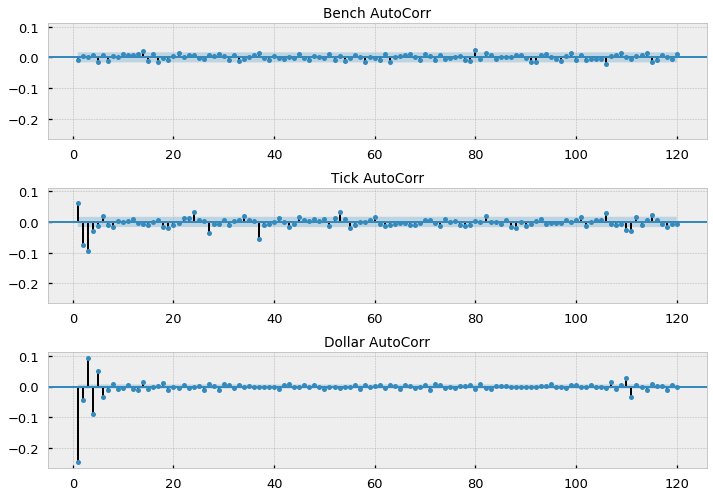

In [11]:
plot_autocorr(bar_types=['Bench', 'Tick', 'Dollar'], bar_returns=[bench_ret, tick_ret, dv_ret])

95956it [00:28, 3362.59it/s]


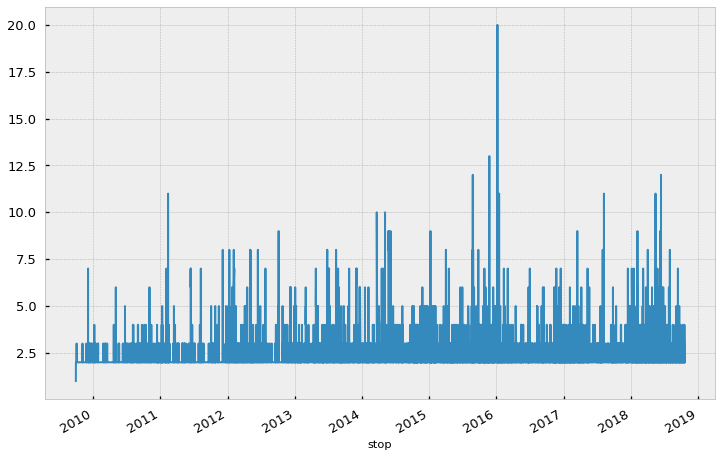

In [12]:
imb_bars, df_ts = get_imbalanced_df(dv_bar_df, price_column='price', imbalanced_column='dv',wsize=1000)
#imb_bars = get_imbalanced_df(df=dv_bar_df)

In [13]:
infp = PurePath(data_dir/'processed'/'IVE_dollarValue_resampled_1s.parquet')
df = pd.read_parquet(infp)
#cprint(df)

In [14]:
dv_1s_ret = returns(df.price)
imb_ret = returns(imb_bars.price)
bar_types= ['Bench','Tick', 'Dollar', 'Imb', 'Dollar1s'] 
bar_returns = [bench_ret, tick_ret, dv_ret, imb_ret, dv_1s_ret]

In [15]:
#get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')

In [16]:
#get_test_stats(bar_types,bar_returns,shapiro).sort_values('shapiro_stat')[::-1]

In [17]:
#outfp = PurePath(data_dir/'processed'/'dv_imbalanced_bars.parq')
#imb_bars = pd.read_parquet(outfp)
#cprint(imb_bars)

In [18]:
close = df.price.copy()
dailyVol = getDailyVol(close, span0=1000)
#cprint(dailyVol.to_frame())

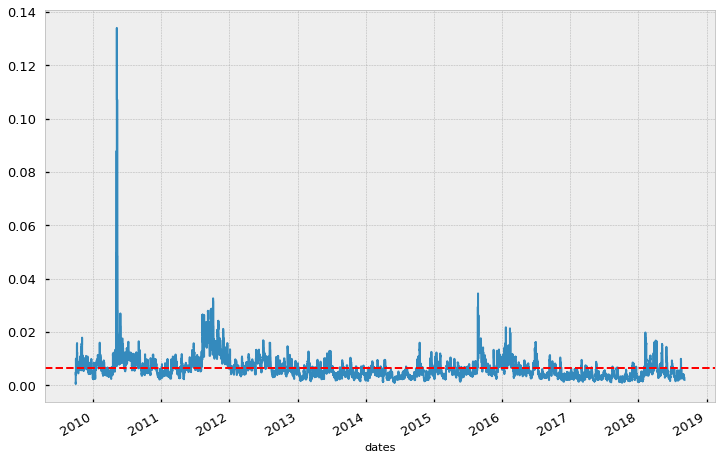

In [19]:
dailyVol.plot()
plt.axhline(dailyVol.mean(),ls='--',color='red')
plt.show()

In [20]:
tEvents = getTEvents(close, h=dailyVol.mean())
#tEvents

100%|██████████| 1010791/1010791 [02:51<00:00, 5879.53it/s]


DatetimeIndex(['2009-09-28 09:47:45', '2009-09-28 11:31:17',
               '2009-09-29 09:03:17', '2009-09-29 10:00:58',
               '2009-09-29 11:00:13', '2009-09-29 13:01:14',
               '2009-09-30 09:43:21', '2009-09-30 09:48:12',
               '2009-09-30 12:32:29', '2009-09-30 13:05:29',
               ...
               '2018-08-16 08:04:29', '2018-08-16 12:03:51',
               '2018-08-17 14:05:16', '2018-08-20 07:00:00',
               '2018-08-20 09:30:00', '2018-08-21 11:40:08',
               '2018-08-23 09:30:00', '2018-08-27 09:30:00',
               '2018-08-30 11:26:38', '2018-08-31 12:07:04'],
              dtype='datetime64[ns]', length=5332, freq=None)

xdf shape: (429,), xtdf shape: (7,)


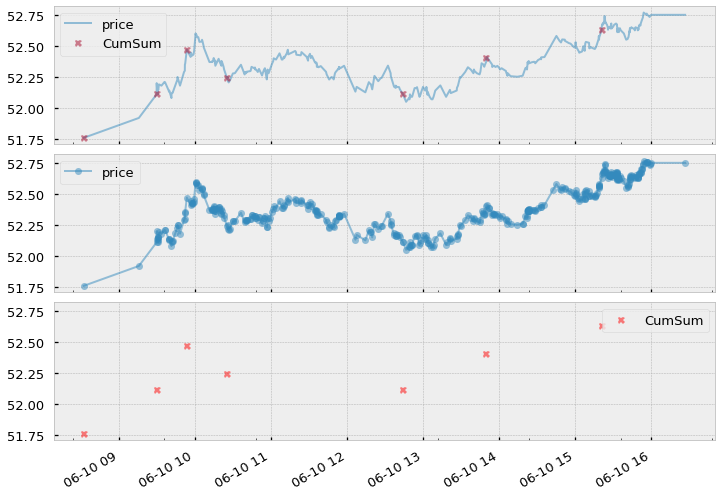

In [21]:
xDate = '2010-06-10'
xdf, xtdf = select_sample_data(df, df.loc[tEvents], 'price', xDate)
print(f'xdf shape: {xdf.shape}, xtdf shape: {xtdf.shape}')

plot_sample_data(xdf, xtdf, 'CumSum', alpha=0.5, markersize=7)  

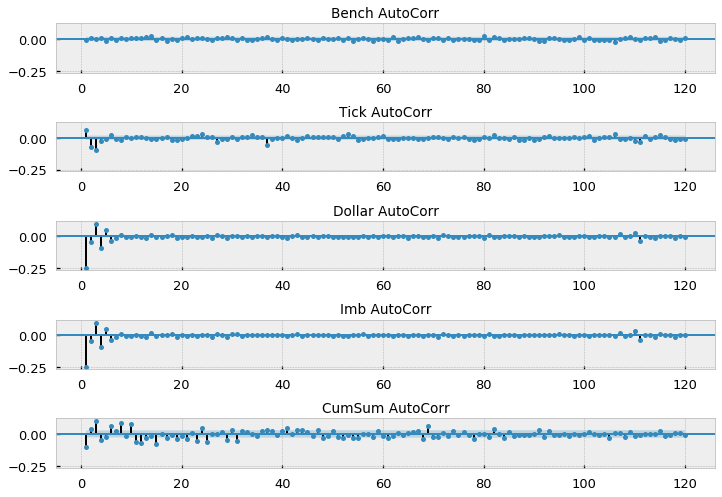

In [22]:
cum_sum_ret = returns(df.loc[tEvents].price)
bar_types= ['Bench','Tick', 'Dollar', 'Imb', 'CumSum'] 
bar_returns = [bench_ret, tick_ret, dv_ret, imb_ret, cum_sum_ret]
plot_autocorr(bar_types=bar_types, bar_returns=bar_returns)

In [23]:
get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')

,sample_size,jb_stat
Bench,14308.0,2.590599e-02
CumSum,5331.0,2.449040e+06
Tick,14308.0,1.322573e+08
Dollar,95956.0,4.955953e+11
Imb,95955.0,4.956197e+11


In [24]:
get_test_stats(bar_types,bar_returns,shapiro).sort_values('shapiro_stat')[::-1]

,sample_size,shapiro_stat
Bench,14308.0,0.999901
CumSum,5331.0,0.673030
Tick,14308.0,0.656786
Dollar,95956.0,0.319394
Imb,95955.0,0.319378


In [25]:
t1 = addVerticalBarrier(tEvents, close)

In [38]:
ptsl = [1,1]
target=dailyVol
# select minRet
minRet = 0.01
# get cpu count - 1
cpus = 1
events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)
#cprint(events)

In [39]:
events_ = events.dropna(subset=['t1'])
print(events.shape, events_.shape)
px = events_.index.union(events_['t1'].values).drop_duplicates()
px = close.reindex(px, method='bfill')
out  = pd.DataFrame(index=events_.index)
out['ret'] = px.loc[events_['t1'].values].values/px.loc[events_.index.values].values - 1
if 'side' in events_: out['ret'] *= events_['side']

out['bin'] = np.sign(out['ret'])

if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0 #meta-labeling
    
#cprint(out)

(1856, 2) (1856, 2)


In [40]:
labels = getBins(events, close)
clean_labels = dropLabels(labels)
clean_labels.bin.value_counts()

dropped label:  0.0 0.0016163793103448276


 1.0    1031
-1.0     822
Name: bin, dtype: int64

## [3.5] Develop mean-reverting Bollinger Band Strategy. For each obs. model suggests a side but not size of the bet.

In [41]:
window=50
bb_df = pd.DataFrame()
bb_df['price'],bb_df['ave'],bb_df['upper'],bb_df['lower']=bbands(close, window=window, numsd=1)
bb_df.dropna(inplace=True)
#cprint(bb_df)

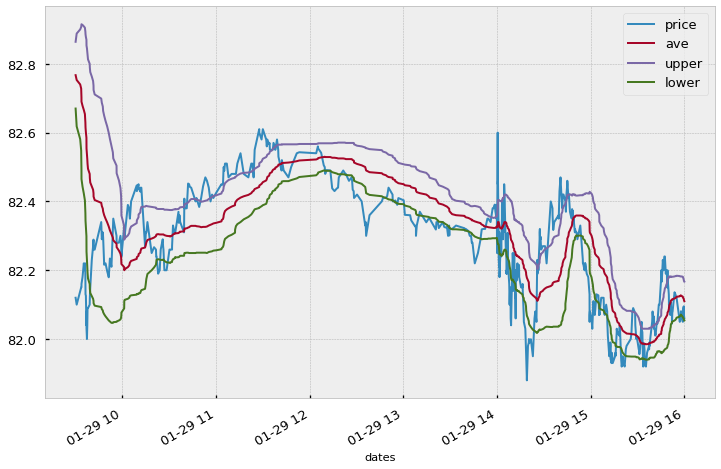

In [42]:
from_date, to_date = '2014-01-29', '2014-01-29'
bb_df.loc[from_date:to_date].plot()
plt.show()

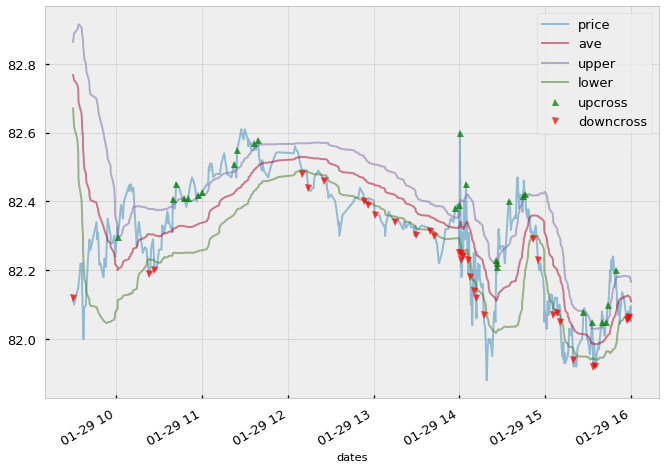

In [43]:
bb_down = get_down_cross(bb_df, 'price')
bb_up = get_up_cross(bb_df, 'price') 

f, ax = plt.subplots(figsize=(11,8))

bb_df.loc[from_date:to_date].plot(ax=ax, alpha=.5)
bb_up.loc[from_date:to_date].plot(ax=ax, ls='', marker='^', markersize=7,
                        alpha=0.75, label='upcross', color='g')
bb_down.loc[from_date:to_date].plot(ax=ax, ls='', marker='v', markersize=7, 
                          alpha=0.75, label='downcross', color='r')
ax.legend()

In [44]:
bb_side_up = pd.Series(-1, index=bb_up.index) # sell on up cross for mean reversion
bb_side_down = pd.Series(1, index=bb_down.index) # buy on down cross for mean reversion
bb_side_raw = pd.concat([bb_side_up,bb_side_down]).sort_index()
#cprint(bb_side_raw)

minRet = .01 
ptsl=[0,2]
bb_events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1,side=bb_side_raw)
#cprint(bb_events)

bb_side = bb_events.dropna().side

In [45]:
bb_side.value_counts()

-1.0    165
 1.0    135
Name: side, dtype: int64

In [46]:
bb_bins = getBins(bb_events,close).dropna()

In [47]:
bb_bins.bin.value_counts()

0.0    172
1.0    128
Name: bin, dtype: int64

In [48]:
srl_corr = df_rolling_autocorr(returns(close), window=window).rename('srl_corr')
#cprint(srl_corr)

In [49]:
features = (pd.DataFrame()
            .assign(vol=bb_events.trgt)
            .assign(side=bb_side)
            .assign(srl_corr=srl_corr)
            .drop_duplicates()
            .dropna())
#cprint(features)

In [50]:
Xy = (pd.merge_asof(features, bb_bins[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
#cprint(Xy)

In [51]:
Xy.bin.value_counts()

0.0    172
1.0    128
Name: bin, dtype: int64

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X = Xy.drop('bin',axis=1).values
#print(X[0:3])
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

              precision    recall  f1-score   support

    no_trade       0.56      0.55      0.55        88
       trade       0.38      0.40      0.39        62

   micro avg       0.49      0.49      0.49       150
   macro avg       0.47      0.47      0.47       150
weighted avg       0.49      0.49      0.49       150



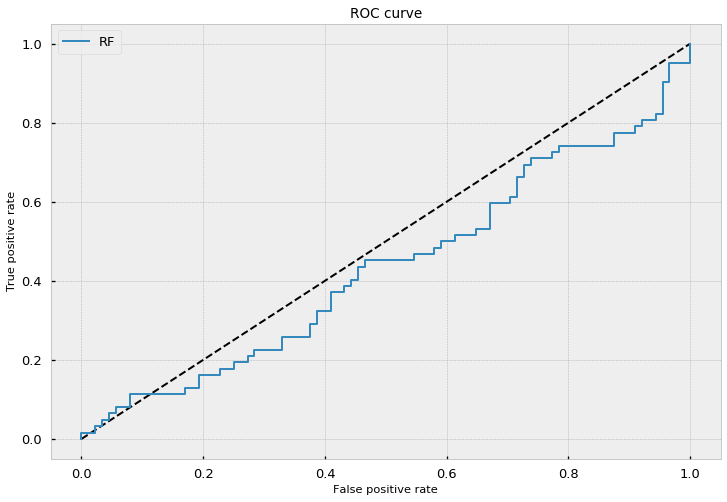

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, classification_report

n_estimator = 10000
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names=['no_trade','trade']))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [55]:
coEvents = mpNumCoEvents(closeIdx=events.index, t1=events.t1, molecule=events.index)

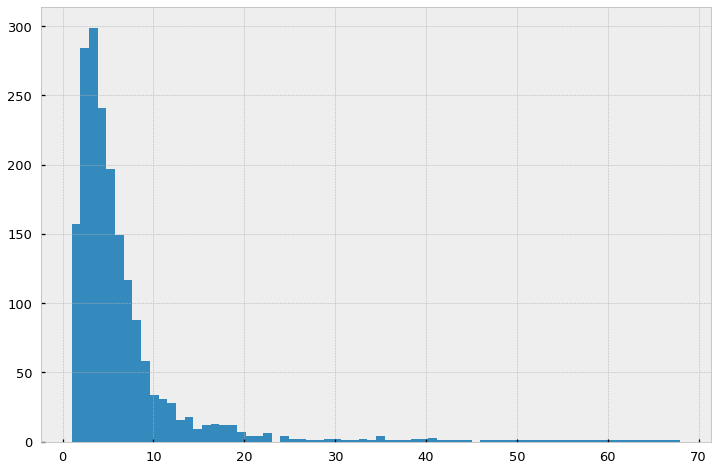

In [58]:
plt.hist(coEvents, bins=70)
plt.show()

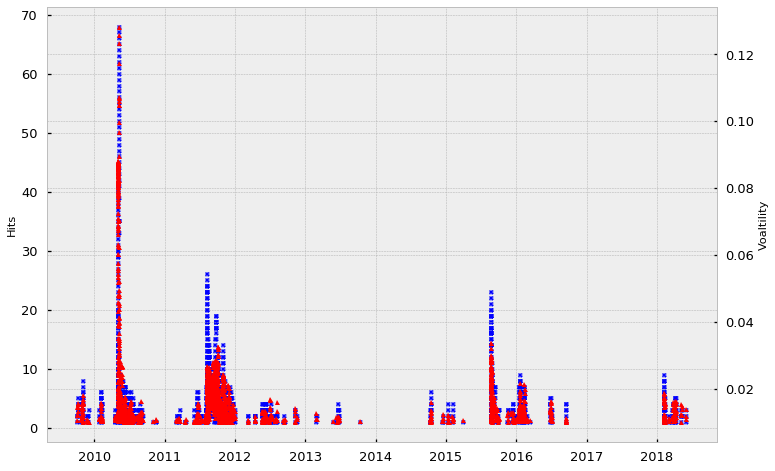

In [59]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(coEvents.index, coEvents.values, 'b-', ls='', marker='X', markersize=5)
ax1.set_ylabel('Hits')
ax2 = ax1.twinx()
ax2.set_ylabel('Voaltility')
ax2.plot(dailyVol[coEvents.index].index, dailyVol[coEvents.index].values, color='red', ls='', marker='^', markersize=5)

[]

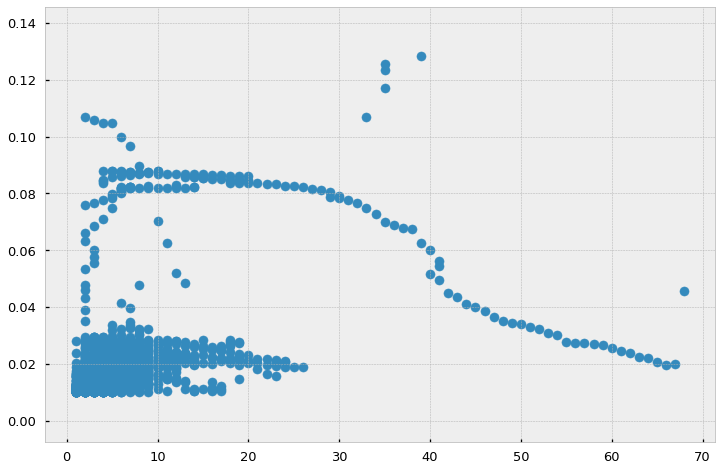

In [61]:
#coEvents.shape, dailyVol[coEvents.index].shape
#plt.figure(figsize=(12, 8))
plt.scatter(coEvents.values, dailyVol[coEvents.index].values)
plt.plot()

In [62]:
def mpSampleTW(t1, numCoEvents, molecule):
    # Derive average uniqueness over the event's lifespan
    wght = pd.Series(index=molecule)
    for tIn, tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn] = (1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

In [66]:
numThreads = 1
numCoEvents = coEvents.loc[~coEvents.index.duplicated(keep='last')]
#numCoEvents = numCoEvents.reindex(close.index).fillna(0)
numCoEvents = mpPandasObj(mpSampleTW, ('molecule', events.index), numThreads, t1=events.t1, numCoEvents=numCoEvents)
numCoEvents.shape

(1856,)

In [67]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])

#np.corrcoef(numCoEvents.values[:-1], numCoEvents.values[1:])
acf(numCoEvents.values, length=2)[1]

0.7612153773295198

In [68]:
cprint(numCoEvents)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                            0
2018-05-09 09:30:00  0.416667
2018-05-09 12:50:36  0.333333
2018-05-31 09:43:56  0.611111
2018-05-31 14:01:41  0.416667
2018-06-01 09:30:00  0.333333
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1856 entries, 2009-10-05 10:09:17 to 2018-06-01 09:30:00
Data columns (total 1 columns):
0    1856 non-null float64
dtypes: float64(1)
memory usage: 29.0 KB
None
-------------------------------------------------------------------------------



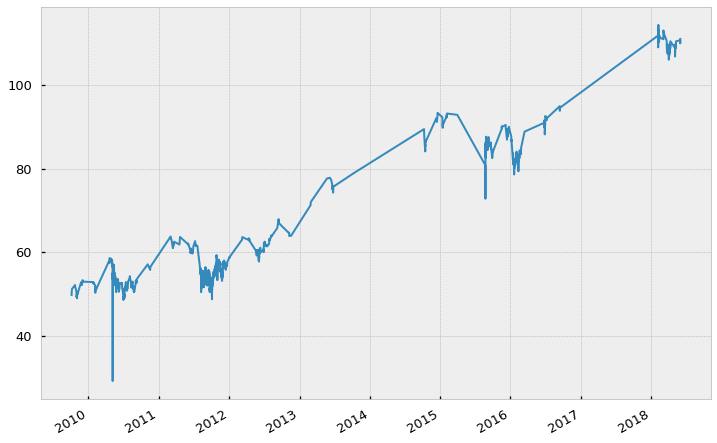

In [70]:
df.loc[numCoEvents.index, 'price'].plot()
plt.show()

In [74]:
df0 = dv_bar_df.resample('1D').last()

In [78]:
name = 'price'

#w = getWeights_FFD(d=0.8, thres=0.01)
#f = fracDiff_FFD(series=df0, d=0.3, thres=0.001)
#f
correlations = []
for d in np.linspace(0, 1, 21):
    #print(d)
    df1 = np.log(df0[[name]])
    #print(df1.head())
    df2 = fracDiff_FFD(df1, d, thres=.001)
    corr = np.corrcoef(df1.loc[df2.index, name], df2[name])[0,1]
    correlations.append(corr)
    print(d, corr)

0.0 1.0
0.05 0.9999063593268019
0.1 0.999348556324113
0.15000000000000002 0.9979442237604457
0.2 0.9954178196485713
0.25 0.9912400914731272
0.30000000000000004 0.9849716022642064
0.35000000000000003 0.9754075670277144
0.4 0.9617356993399394
0.45 0.9424686425194163
0.5 0.9145094816966083
0.55 0.8763950033218549
0.6000000000000001 0.829053599561844
0.65 0.7659076726078596
0.7000000000000001 0.692514323526617
0.75 0.6124032544843921
0.8 0.5309922238554993
0.8500000000000001 0.4291480175002812
0.9 0.32264420065397814
0.9500000000000001 0.2217142846918492
1.0 0.013150269092276465


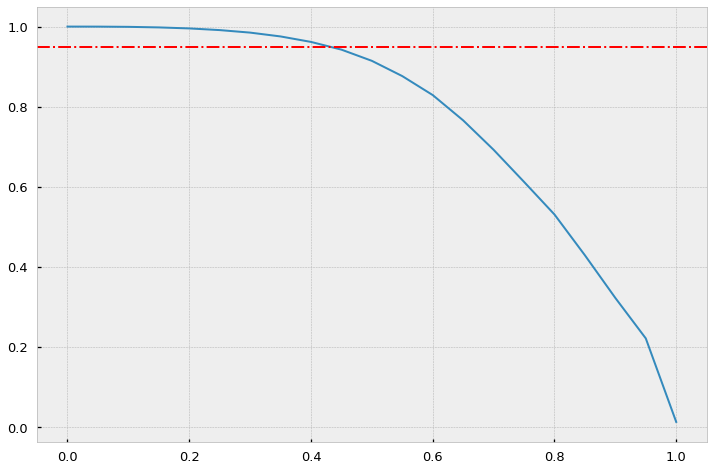

In [79]:
correlations = np.array(correlations).reshape((-1, 1))
xValues = np.linspace(0, 1, 21)
#plt.figure(figsize=(12,8))
plt.plot(xValues, correlations)
plt.axhline(y=0.95, color='red', ls='-.')
plt.show()

In [80]:
best_d = 0.45
df2 = fracDiff_FFD(df1, d, thres=.001)

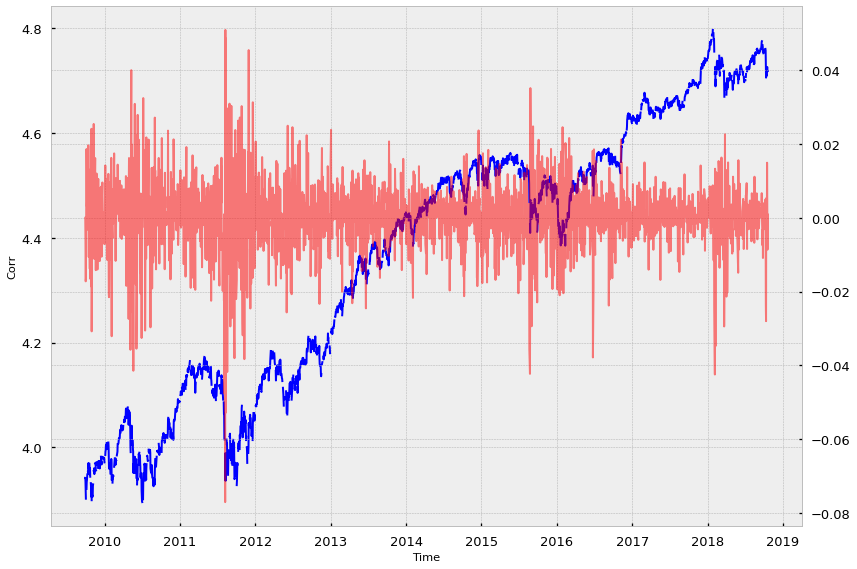

In [81]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(df1.price, 'b-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')

ax2 = ax1.twinx()
ax2.plot(df2.price, color='red', alpha=0.5)
#ax1.set_xlabel('Time')
ax1.set_ylabel('Corr')

#ax2.set_ylabel('sin', color='r')
#ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               price
2018-10-15 -0.000990
2018-10-16  0.014926
2018-10-17  0.001064
2018-10-18 -0.008633
2018-10-19  0.000893
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2282 entries, 2009-09-29 to 2018-10-19
Data columns (total 1 columns):
price    2282 non-null float64
dtypes: float64(1)
memory usage: 115.7 KB
None
-------------------------------------------------------------------------------



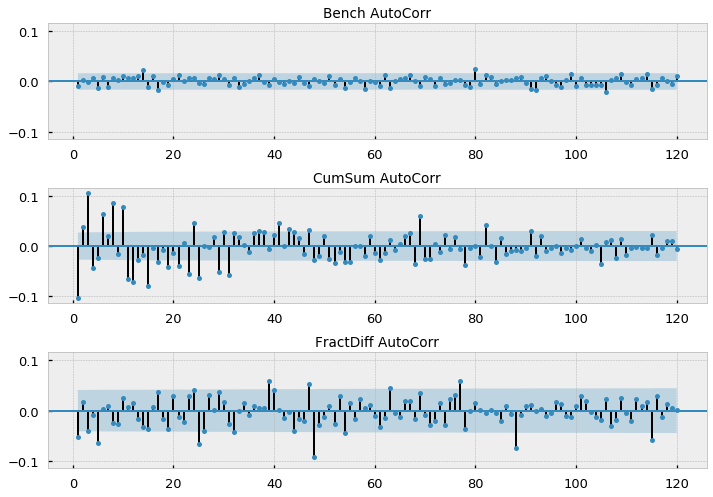

In [99]:
bar_types= ['Bench','CumSum', 'FractDiff'] 
bar_returns = [bench_ret, cum_sum_ret, df2.price]
plot_autocorr(bar_types=bar_types, bar_returns=bar_returns)